In [65]:
import sys
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos,arctan,trace
from torch.utils.data import DataLoader
from func import OR,heatplot,ipfread,misorientation,find_neigh,classplot,ipfplot
from Class import Data,Cluster,Dataset
import torch.nn.functional as F
import matplotlib.patches as patches
from multiprocessing import Process, Pool
from sklearn.mixture import GaussianMixture

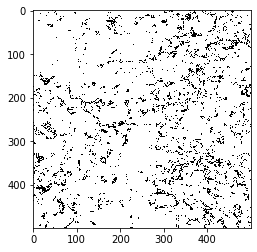

In [5]:
data=Data("data/test/20201109/before/")
ipf=ipfread("data/test/20201109//before/")
orient=data.data["Orient"]
phase=data.data["Phase"]
inv = np.load("new_inv.npy")
h,w=orient.shape[0],orient.shape[1]
orient_inv=np.empty([h,w,3,3])
for i in range(h):
    for j in range(w):
        orient_inv[i,j]=np.linalg.inv(orient[i,j])
plt.imshow(data.data["Phase"],cmap="gray")

In [66]:
type1=np.empty([3*h*(w-1),3])
ite=0
for i in range(h):
    for j in range(w-1):
        type1[ite*3:ite*3+3,:]=np.matmul(orient[i,j],orient_inv[i,j+1])
        ite+=1
res1=np.matmul(type1,inv)
res1=arccos((np.max(np.trace(res1.reshape([h*(w-1),3,72]).reshape(h*(w-1),3,3,24,order="F"),axis1=1,axis2=2),axis=1)-1)/2)/pi*180
edge_h=res1.reshape([h,w-1])

type2=np.empty([3*(h-1)*w,3])
ite=0
for i in range(h-1):
    for j in range(w):
        type2[ite*3:ite*3+3,:]=np.matmul(orient[i,j],orient_inv[i+1,j])
        ite+=1
res2=np.matmul(type2,inv)
res2=arccos((np.max(np.trace(res2.reshape([(h-1)*w,3,72]).reshape((h-1)*w,3,3,24,order="F"),axis1=1,axis2=2),axis=1)-1)/2)/pi*180
edge_v=res2.reshape([h-1,w])


In [67]:
vertex=set()
for i in range(h):
    for j in range(w):
        vertex.add((i,j))
# class_map=-(1-phase)
class_map=np.zeros([h,w])
id2clus=dict()
to_travel=set()
c=1
t=3
while len(vertex)!=0:
    i,j=vertex.pop()
    id2clus[c]=Cluster(c,i,j)
    class_map[i,j]=c
    if phase[i,j]==0:
        c+=1
        continue
    to_travel.add((i,j))
    while len(to_travel)!=0:
        k,l=to_travel.pop()
        class_map[k,l]=c
        id2clus[c].add(k,l)
        for (m,n) in find_neigh((k,l),h,w):
            if k==m: #type2
                if edge_h[k,min(l,n)]>t:
                    continue
            elif l==n: #type1
                if edge_v[min(k,m),l]>t:
                    continue    
            if phase[m,n]!=0:
                if (m,n) in vertex:
                    vertex.remove((m,n))
                if class_map[m,n]==0:
                    to_travel.add((m,n))        
    c+=1



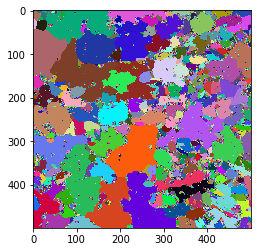

True

In [68]:
cv2.imwrite("output/20201109_class_1.png",classplot(class_map))

In [69]:
num=[]
for i in range(1,c):
    if i in id2clus:
        if id2clus[i].num!=1:
            num.append(id2clus[i].num)

X = np.array(num).reshape(-1,1)
gm = GaussianMixture(n_components=2, random_state=0,tol=1e-5).fit(X)
print(gm.means_)
gs=np.mean(gm.means_)
ma_pixels=set()
for id in list(id2clus.keys()):
    if id2clus[id].num<gs:
        for (i,j) in id2clus[id].pixels:
            ma_pixels.add((i,j))


[[  3.12687974]
 [294.72023593]]


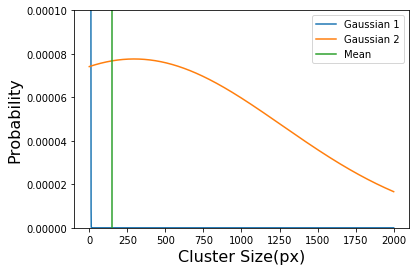

In [70]:
# gm.means_,gm.covariances_
import scipy
plt.ylim(0,1e-4)
x_values = np.arange(0, 2000, 0.1)
y_values_1 = scipy.stats.norm(gm.means_[0],gm.covariances_[0][0]**0.5)
y_values_2 = scipy.stats.norm(gm.means_[1],gm.covariances_[1][0]**0.5)
# plt.yscale("log")
p1,=plt.plot(x_values, gm.weights_[0]*y_values_1.pdf(x_values))
p2,=plt.plot(x_values, gm.weights_[1]*y_values_2.pdf(x_values))
p3,=plt.plot(np.ones([101])*gs,np.arange(0,1e-4,1e-6))
plt.legend([p1,p2,p3],["Gaussian 1","Gaussian 2","Mean"])
plt.xlabel("Cluster Size(px)",fontsize=16)
plt.ylabel("Probability",fontsize=16)

plt.savefig("output/gmm.png",dpi=600,bbox_inches='tight')

True

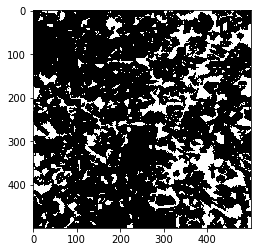

In [71]:
new_map=np.zeros([h,w])
for (i,j) in ma_pixels:
    new_map[i,j]=1
plt.imshow(new_map,cmap="gray")
cv2.imwrite("output/20201109_class_2.png",new_map*255)

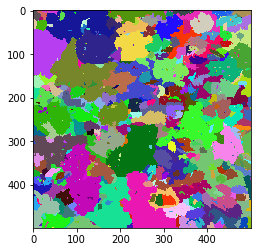

True

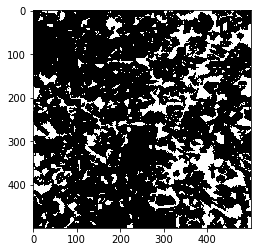

In [72]:
ma_id=set()
while len(ma_pixels)>0:
    to_travel={ma_pixels.pop()}
    to_merge=set()
    while len(to_travel)>0:    
        i,j=to_travel.pop()
        to_merge.add(class_map[i,j])        
        for (k,l) in find_neigh((i,j),h,w):
            if (k,l) in ma_pixels:
                to_travel.add((k,l))
                ma_pixels.remove((k,l))
    main=to_merge.pop()
    ma_id.add(main)
    while len(to_merge)>0:
        be_merge=to_merge.pop()
        for (k,l) in id2clus[be_merge].pixels:
            class_map[k,l]=main
            id2clus[main].pixels.add((k,l))
        id2clus[main].num+=id2clus[be_merge].num
        del id2clus[be_merge]
ma_map=np.zeros([h,w])
for id in ma_id:
    for (i,j) in id2clus[id].pixels:
        ma_map[i,j]=1
classplot(class_map)
plt.imshow(ma_map,cmap="gray")    
cv2.imwrite("output/20201109_class_3.png",ma_map*255)


In [73]:
for id in list(id2clus.keys()):
    neigh=set()
    if id2clus[id].num>=gs:
        continue
    for (i,j) in id2clus[id].pixels:
        for (k,l) in find_neigh((i,j),h,w):
            if class_map[k,l]!=id:
                neigh.add(class_map[k,l])
    main=-1
    largest_num=0
    while len(neigh)>0:
        ele=neigh.pop()
        if id2clus[ele].num>largest_num:
            largest_num=id2clus[ele].num
            main=ele
    for (k,l) in id2clus[id].pixels:
        class_map[k,l]=main
        id2clus[main].pixels.add((k,l))
    id2clus[main].num+=id2clus[id].num
    del id2clus[id]
    if id in ma_id:
        ma_id.remove(id)
    
        
        

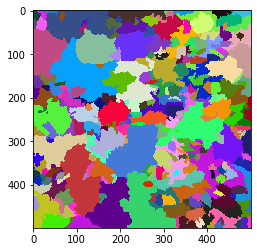

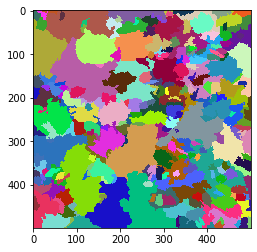

True

In [77]:
ma_map=np.zeros([h,w])
for id in ma_id:
    for (i,j) in id2clus[id].pixels:
        ma_map[i,j]=1
classplot(class_map)
plt.imshow(ma_map,cmap="gray")
cv2.imwrite("output/20201109_class_4.png",classplot(class_map))


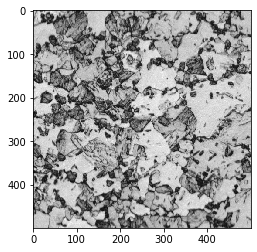

In [14]:
plt.imshow(data.get("BC"),cmap="gray")